In [ ]:
%pip install gdown --quiet
import gdown
import os

# Download every files needed "Data + Emotion_recognition_net.pth"

folder_id = "18dw24emFGjEXr_IT94lGFjvt7DDR2kBM"

gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)
os.rename("18dw24emFGjEXr_IT94lGFjvt7DDR2kBM", "Data")

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

## Dataset

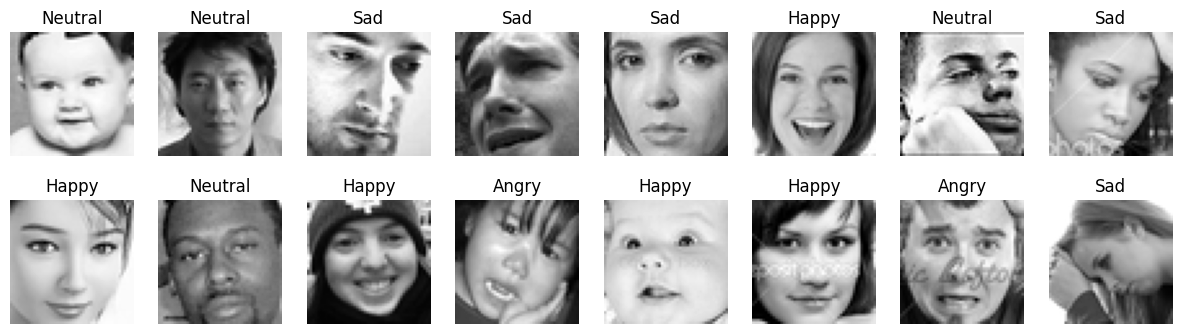

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), #Setting this temporary transform to visualize
    transforms.ToTensor()                        #Will applicate standardization later
])

trainset = datasets.ImageFolder(root="Data/train", transform=transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

images, labels = next(iter(trainloader)) #images.shape = torch.Size([16, 1, 48, 48])
classes = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]

fig, axes = plt.subplots(2, 8, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0], cmap="gray")
    ax.set_title(classes[labels[i]])
    ax.axis("off")
plt.show()

## Computing mean and std

In [3]:
def compute_Mean_Std(loader): #Computing mean and std to apply better transform
    mean = 0
    var = 0
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1) #images.shape = torch.Size([16, 1, 2304])
        mean += images.mean(2).sum(0)
        var += images.var(2).sum(0)
        total_images += batch_samples
    
    mean /= total_images
    std = np.sqrt(var/total_images)

    return mean, std

mean, std = compute_Mean_Std(trainloader)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.5033])
Std: tensor([0.2183])


In [5]:
transform_std = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5033,), (0.2183,))
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5033,), (0.2183,))
])

trainset = datasets.ImageFolder(root="Data/train", transform=transform_std)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

testset = datasets.ImageFolder(root="Data/test", transform=transform_test)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

## CNN

In [6]:
class Net(nn.Module):
    def __init__(self, input_channels=1, num_classes=5):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.35)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, num_classes)

        self.drop_fc = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.drop3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.drop4(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = F.relu(self.fc2(x))
        x = self.drop_fc(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used :", device)

Device used : cuda


In [8]:
net = Net()
net.to(device)
#net.load_state_dict(torch.load("Emotion_recognition_net.pth"))
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-7, weight_decay=1e-4)

In [8]:
def net_Training(n_epoch, net, criterion, optimizer, trainloader, testloader):
    train_losses = []
    val_losses = []
    for epoch in range(n_epoch):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(testloader)
        val_losses.append(val_loss)
        accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{n_epoch} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")
        
    print('Finished Training')
    PATH = './Emotion_recognition_net.pth'
    torch.save(net.state_dict(), PATH)
        
    return train_losses, val_losses

def print_Stats(n_epoch, net, criterion, optimizer, trainloader, testloader):
    train_losses, val_losses = net_Training(n_epoch, net, criterion, optimizer, trainloader, testloader)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Courbes de Loss')
    plt.show()

Epoch 1/50 | Train Loss: 1.5748 | Val Loss: 1.5185 | Val Acc: 30.35%
Epoch 2/50 | Train Loss: 1.4904 | Val Loss: 1.4393 | Val Acc: 36.94%
Epoch 3/50 | Train Loss: 1.4044 | Val Loss: 1.2803 | Val Acc: 47.08%
Epoch 4/50 | Train Loss: 1.1894 | Val Loss: 1.0910 | Val Acc: 55.67%
Epoch 5/50 | Train Loss: 1.0950 | Val Loss: 1.0126 | Val Acc: 57.06%
Epoch 6/50 | Train Loss: 1.0312 | Val Loss: 0.9419 | Val Acc: 61.41%
Epoch 7/50 | Train Loss: 0.9793 | Val Loss: 0.9391 | Val Acc: 62.45%
Epoch 8/50 | Train Loss: 0.9437 | Val Loss: 0.8931 | Val Acc: 63.88%
Epoch 9/50 | Train Loss: 0.9201 | Val Loss: 0.8795 | Val Acc: 65.94%
Epoch 10/50 | Train Loss: 0.9027 | Val Loss: 0.8712 | Val Acc: 66.18%
Epoch 11/50 | Train Loss: 0.8854 | Val Loss: 0.8585 | Val Acc: 67.10%
Epoch 12/50 | Train Loss: 0.8668 | Val Loss: 0.8393 | Val Acc: 67.48%
Epoch 13/50 | Train Loss: 0.8543 | Val Loss: 0.8065 | Val Acc: 69.10%
Epoch 14/50 | Train Loss: 0.8455 | Val Loss: 0.7997 | Val Acc: 69.77%
Epoch 15/50 | Train Loss: 0.8

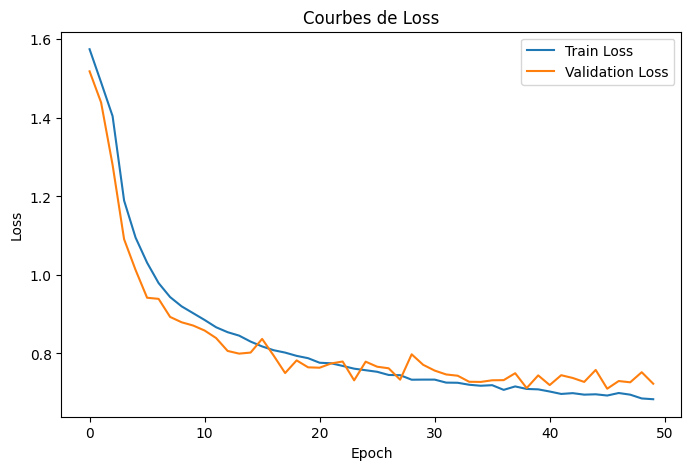

In [21]:
print_Stats(50, net, criterion_2, optimizer_2, trainloader, testloader)

## Evaluation

In [9]:
def evaluate_per_class(net, testloader, num_classes=5):
    net.eval()
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes
    total_acc = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    correct_per_class[label] += 1
                total_per_class[label] += 1

    print("Precision by class :")
    for c in range(num_classes):
        if total_per_class[c] > 0:
            accuracy_c = 100 * correct_per_class[c] / total_per_class[c]
            total_acc += correct_per_class[c]
            total += total_per_class[c]
        else:
            accuracy_c = 0
        print(f"Class {c+1}: {accuracy_c:.2f}% ({correct_per_class[c]}/{total_per_class[c]})")
    
    print(f"Total : {100 * total_acc / total:.2f}%")

In [39]:
evaluate_per_class(net, testloader)

Precision by class :
Class 1: 56.37% (540/958)
Class 2: 87.99% (1561/1774)
Class 3: 74.61% (920/1233)
Class 4: 59.42% (741/1247)
Class 5: 79.90% (664/831)
Total : 73.24%


## Camera

In [9]:
#emotion class labels (index → label)
class_names = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]

#normalization values from our dataset
mean = 0.5033
std  = 0.2183

#globals: model, device, face detector
_model = None
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

#image preprocessing pipeline
_to_tensor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def set_model(model):
    global _model
    _model = model.to(_device).eval()

def _preprocess(bgr_face):
    #convert BGR (OpenCV) → RGB → PIL → tensor
    rgb = cv2.cvtColor(bgr_face, cv2.COLOR_BGR2RGB)
    pil = transforms.ToPILImage()(rgb)
    x = _to_tensor(pil).unsqueeze(0)
    return x.to(_device)

def imageProcess(frame):
    if _model is None:
        cv2.putText(frame, "Model not loaded", (10,25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        return

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = _cascade.detectMultiScale(gray, 1.2, 5, minSize=(60,60))

    if len(faces) == 0:
        cv2.putText(frame, "No face", (10,25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        return

    #select the largest detected face
    x,y,w,h = sorted(faces, key=lambda r:r[2]*r[3], reverse=True)[0]
    face = frame[y:y+h, x:x+w]

    with torch.no_grad():
        inp = _preprocess(face)
        logits = _model(inp)              # shape [1, num_classes]
        prob = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred = int(np.argmax(prob))
        label = class_names[pred]
        conf = float(prob[pred])

    #draw bounding box and showing prediction
    cv2.rectangle(frame, (x,y), (x+w,y+h), (0,200,0), 2)
    text = f"{label} ({conf*100:.0f}%)"
    cv2.putText(frame, text, (x, y-8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,0), 2)

In [10]:
#path to pre-trained checkpoint here it is emotion_recognition_net.pth
CKPT = "Emotion_recognition_net.pth"

def load_model(num_classes=5, ckpt_path=CKPT):
    """Load CNN model from checkpoint"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = Net(input_channels=1, num_classes=num_classes).to(device)
    try:
        state = torch.load(ckpt_path, map_location=device)
        if isinstance(state, dict) and "model" in state:
            net.load_state_dict(state["model"])
        else:
            net.load_state_dict(state)
    except Exception as e:
        print(f"Could not load checkpoint")
    return net.eval()

def videoCapture():
    """Start webcam feed and run real-time emotion recognition."""
    model = load_model(num_classes=5, ckpt_path=CKPT)
    set_model(model)

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot access camera")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        imageProcess(frame)
        h, w, _ = frame.shape

        #display quit instruction
        cv2.putText(frame, "Press SPACE to quit", (10, h - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        cv2.imshow("Emotion Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord(' '):
            break

    cap.release()
    cv2.destroyAllWindows()

#entry point
videoCapture()